# Using Meeshkan for developing Kaggle kernels
Example of using Meeshkan to get notifications and remotely control jobs from Kaggle kernel.

For a full example of how to submit this kernel to Kaggle, see [GitHub](https://github.com/Meeshkan/meeshkan-client/tree/dev/examples/kaggle).

### Install dependencies
Let us first install all the dependencies we need. Note that as of February 2018, installing `tensorflow` requires Python < 3.7.

In [1]:
!pip install keras tensorflow meeshkan pandas scikit-learn

In [2]:
import os
import random

import meeshkan

import keras

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor

Using TensorFlow backend.


Check that data has been downloaded and it's available:

In [3]:
print(os.listdir("../input"))

['test_images', 'breed_labels.csv', 'test_metadata.zip', 'test_images.zip', 'test', 'train_images.zip', 'train_metadata', 'color_labels.csv', 'test_sentiment', '.gitkeep', 'test_metadata', 'test.zip', 'train_sentiment', 'test_sentiment.zip', 'train_sentiment.zip', 'train', 'filename_without_extension', 'train_metadata.zip', 'train_images', 'state_labels.csv', 'train.zip']


### Setting up Meeshkan

To use Meeshkan, you need to 
1. register at [meeshkan.com](https://meeshkan.com) and get your API key
1. setup Slack integration as instructed in the [docs](https://www.meeshkan.com/docs)

The API key is configured with the `meeshkan.init(token=YOUR_API_KEY)` command. **Make sure to replace the example API key below with your own key!**

In [4]:
# Run this the first time you're using Meeshkan 
# meeshkan.init(token="YOUR_API_KEY")  # REPLACE THIS WITH YOUR API_KEY
meeshkan.init()  # Run this if `meeshkan.init(token=...)` has been called before (~.meeshkan/credentials exists)

Service started.


Meeshkan agent can be used to schedule multiple machine learning jobs, but here we can simply use the [@meeshkan.as_blocking_job](https://meeshkan-client.readthedocs.io/en/latest/#meeshkan.as_blocking_job) decorator to define our jobs. Execute the cell below and make sure you get a Slack notification for a job being started and finished:

In [5]:
import time
@meeshkan.as_blocking_job(job_name="test-job", report_interval_secs=10)
def train():
    for i in range(10):
        meeshkan.report_scalar("Random number", random.uniform(0, 1))
        time.sleep(2)
        
train()

If everything works as expected, we can get rocking with machine learning!

### Run your job

To keep this demo as simple as possible, we will only use the `Age` column to try and predict `AdoptionSpeed`. First load data and peek into first rows:

In [6]:
train_df = pd.read_csv("../input/train/train.csv")
train_df.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


Check what the columns look like:

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

Let us check how `Age` compares to `AdoptionSpeed`:

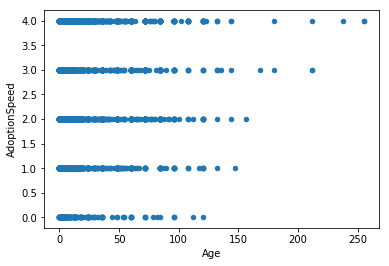

In [8]:
train_df.plot(x="Age", y="AdoptionSpeed", kind="scatter")

Obviously the correlation is not very good and age of zero should be taken into account. For the purposes of this example, we'll anyway just use `Age` to try to predict `AdoptionSpeed`.

Let us create a training and validation set from `train_df`:

In [9]:
from sklearn.model_selection import train_test_split

TRAIN_COLUMNS = ['Age']

X = train_df[TRAIN_COLUMNS].values
y = train_df['AdoptionSpeed'].values

# Normalize input and output
X_scaler = sklearn.preprocessing.MinMaxScaler()
y_scaler = sklearn.preprocessing.MinMaxScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.reshape(-1, 1))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True)

/Users/kimmo/.pyenv/versions/3.6.5/envs/kaggle-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/kimmo/.pyenv/versions/3.6.5/envs/kaggle-3.6.5/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)

X_train: (11994, 1)
y_train: (11994, 1)
X_val: (2999, 1)
y_val: (2999, 1)


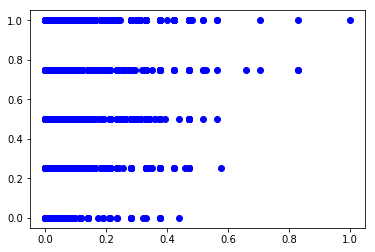

In [11]:
plt.plot(X_train, y_train, 'bo')

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import LambdaCallback
from keras.optimizers import SGD

def build_model():
    model = Sequential()
    model.add(Dense(10, input_dim=len(TRAIN_COLUMNS)))
    model.add(Activation('relu'))
    model.add(Dense(5))
    model.add(Activation('relu'))
    model.add(Dense(1, input_dim=len(TRAIN_COLUMNS)))

    model.compile(loss='mse', optimizer=SGD(lr=1e-3), metrics=['mae'])
    return model

def on_epoch_end(epoch, logs):
    try:
        meeshkan.report_scalar("Train loss", float(logs['loss']), "Train mae", float(logs['mean_absolute_error']))
    except Exception as e:
        print(e)

EPOCHS = 100
VALIDATION_INTERVAL = 1

@meeshkan.as_blocking_job(job_name="train-keras", report_interval_secs=60)
def train(model):
    print('Training -----------')
    
    import time
    time.sleep(1)
    # Add a condition to send notification when MAE is small enough
    meeshkan.add_condition("Train mae", condition=lambda value: value < 0.3)
    
    # Report scalars to Meeshkan at every epoch end
    meeshkan_callback = LambdaCallback(on_epoch_end=on_epoch_end)
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=256,
                        callbacks = [meeshkan_callback])
    return history

model = build_model()

train(model)

Training -----------
Epoch 1/100
11994/11994 [==============================] - 0s 12us/step - loss: 0.4015 - mean_absolute_error: 0.5649
Epoch 2/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.3110 - mean_absolute_error: 0.4827
Epoch 3/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.2456 - mean_absolute_error: 0.4143
Epoch 4/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.1983 - mean_absolute_error: 0.3674
Epoch 5/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.1644 - mean_absolute_error: 0.3382
Epoch 6/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.1402 - mean_absolute_error: 0.3138
Epoch 7/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.1232 - mean_absolute_error: 0.2937
Epoch 8/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.1114 - mean_absolute_error: 0.2775
Epoch 9/100
11994/11994 [=========================

11994/11994 [==============================] - 0s 2us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 71/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 72/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 73/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 74/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 75/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 76/100
11994/11994 [==============================] - 0s 2us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 77/100
11994/11994 [==============================] - 0s 3us/step - loss: 0.0860 - mean_absolute_error: 0.2575
Epoch 78/100
11994/11994 [==============================] - 0s 3us/step - los

You should have received notifications for job being started and, finally, for the job being finished. Here are the notifications I received:

<img src="img/notifications.png" style="height:500px">

Let's plot the predictions for fun:

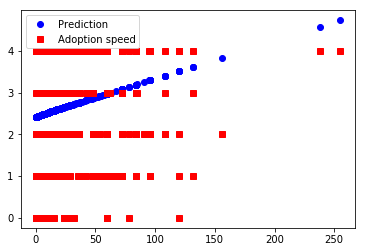

In [13]:
y_pred = model.predict(X_val)

# Perform inverse scalings
X_val_orig = X_scaler.inverse_transform(X_val)

plt.plot(X_val_orig, y_scaler.inverse_transform(y_pred), 'bo', label='Prediction')
plt.plot(X_val_orig, y_scaler.inverse_transform(y_val), 'rs', label='Adoption speed')
plt.legend()

### Teardown

Once we're done, we can stop the Meeshkan agent cleanly:

In [14]:
meeshkan.stop()

Stopping service...
Service stopped.
